In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from tube import Tube, InterpXY, BorderSimple
from gaslayer import GasEOS, GasFluxCalculator, GridStrecher, GasLayer
from math import *
import numpy as np

In [3]:
from tqdm import tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

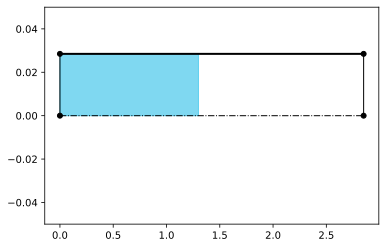

GasLayer(n_cells=300); 
        {'p_max':40000000.0, 'tau_min': 1.2481204644156635e-05, 
        'u_max': 0.0, 'cs_max': 347.18870949384285, 'dx_min': 0.0043333333333333, 
        'x_1': 0.0, 'x_2': 1.3,
        'V_1':  0.0, 'V_2':  0.0  }

In [4]:
def get_layer0(l_0, n_cells=300, d = 57e-3, p_0 = 400e5, ld=50):   
    l = d * ld

    gas_layer_dict_sample = {
        'type': 'gas',
        'name': 'air',
        'gamma': 1.4,
        'kappa': 0,
        'R': 287,
        'T_0': 300, # K
        'W_0': 0.0003,  # м^3 объем газа
        'p_0': p_0, # начальное давление газа
        'u_0': 0,     #начальная скорость
        'x_2': l_0
    }

    tube_dict = {
        'tube_points': [[0, d], [l, d]]
    }

    calc_settings_sample = {
        'cell_dx': 0.0025,
        'n_cells': n_cells,
        'n_cells_min': 13,
        'n_cells_max': 300,
        'GasFluxCalculator_kwargs': { 'flux_type':2 },
        'GridStrecher_kwargs': {}
    }   
    tube=Tube.get_standart(tube_dict)
    gl = GasLayer.get_standart(tube, 0, gas_layer_dict_sample, calc_settings_sample)   
    return gl

gl = get_layer0(1.3)
fig, ax = plt.subplots()
gl.tube.plot(fig, ax)
gl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

gl

In [5]:
def calc_sol_all(l_0, m, ku=0.5):
    gl = get_layer0(l_0, n_cells=300, d = 57e-3, p_0 = 400e5, ld=80)
    ku = 0.5
    lrs = [gl]
    for i in range(100000):
        if gl.xs_borders[-1] >= gl.tube.get_xs()[-1]:
            break
        tau = gl.get_tau_min()*ku
        v_left = gl.Vs_borders[-1] + gl.S[-1] * gl.ps[-1] / m * tau
        gl = gl.step_simple(tau, 0, v_left)
        lrs.append(gl)
    return lrs
lrs = calc_sol_all(l_0=0.88, m=0.5, ku=0.5)

def calc_sol(l_0, m):
    lrs = calc_sol_all(l_0, m)
    V = lrs[-1].Vs_borders[-1]
    return V**2/2*m

In [6]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=10, value=0))
def plotMe(ind):
    param_name = 'us'
    lr = lrs[ind]
    fig, ax = plt.subplots()
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax.plot(xs, ys, color=color, lw=lw)
    plt.grid(True)
    plt.ylabel(param_name)
#     plt.ylim(-1,1)
    plt.title(f't={lr.time*1000} ms; i={ind}')
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=1974, step=10), Output()), _dom_classes=('widg…

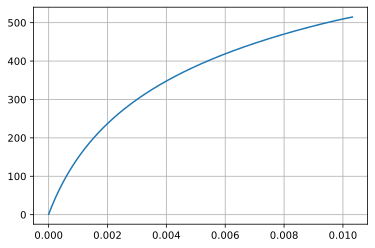

In [7]:
ts = [lr.time for lr in lrs]
vs = [lr.Vs_borders[-1] for lr in lrs]
plt.plot(ts, vs)
plt.grid()
plt.show()

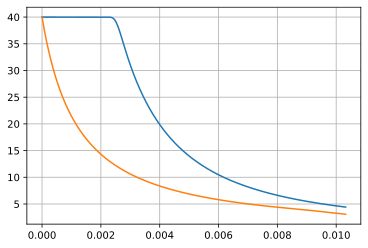

In [8]:
ts = [lr.time for lr in lrs]
ps0 = [lr.ps[0]/1e6 for lr in lrs]
ps1 = [lr.ps[-1]/1e6 for lr in lrs]
plt.plot(ts, ps0)
plt.plot(ts, ps1)
plt.grid()
plt.show()

In [9]:
E = 0.5*vs[-1]**2/2
E


66203.19679295077

In [19]:
%matplotlib inline

In [48]:
from scipy.optimize import minimize

Es = []
xs = []

def min_foo(x):
    E = calc_sol(l_0=x[0], m=0.5)
    Es.append(E)
    xs.append((x[0], 0.5))
    return -E

x0 = [3]

    

res = minimize(min_foo, x0, args=(), method='COBYLA', constraints=(), tol=None, callback=None, 
               options={'rhobeg': 0.4, 'maxiter': 100, 'disp': True, 'catol': 0.02})

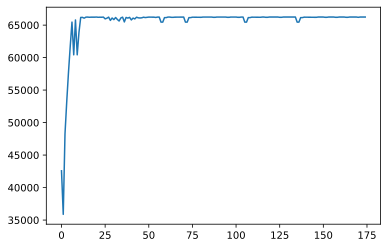

In [54]:
plt.plot(Es)
plt.show()

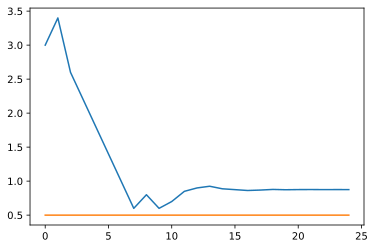

In [50]:
ls = seq(xs).map(lambda x: x[0]).to_list()
ms = seq(xs).map(lambda x: x[1]).to_list()
plt.plot(ls)
plt.plot(ms)
plt.show()

In [31]:
x1 = res.x
res = minimize(min_foo, x1, args=(), method='COBYLA', constraints=(), tol=None, callback=None, 
               options={'rhobeg': 0.1, 'maxiter': 300, 'disp': True, 'catol': 0.0002})

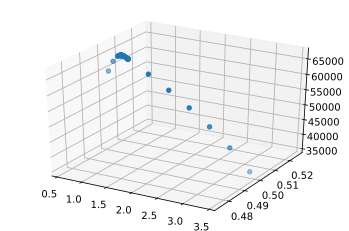

In [53]:
from functional import seq

fig = plt.figure()
ax = fig.gca(projection='3d')

n = 330
ls = seq(xs[-n:]).map(lambda x: x[0]).to_list()
ms = seq(xs[-n:]).map(lambda x: x[1]).to_list()

ax.scatter3D(ls, ms, Es[-n:])
plt.show()

0.8806374914825769

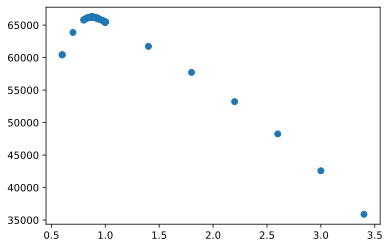

In [56]:
plt.scatter(ls, Es)
ls[np.argmax(Es)]

In [51]:
res.x

array([0.87568125])

In [15]:
res

     fun: -127530.49010540932
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 57
  status: 1
 success: True
       x: array([1.9093913, 5.4689634])

In [36]:
from scipy import optimize


In [52]:
optimize.differential_evolution(min_foo, bounds = [(0.8, 1)])

     fun: -66240.35895680406
     jac: array([-58283.13733218])
 message: 'Optimization terminated successfully.'
    nfev: 150
     nit: 1
 success: True
       x: array([0.88063731])

Итого:

Найти максимальную кинетическую энергию метаемого тела массы $m$ ($m\leq500$ г) для калибра $d$=57 мм. Общая длина трубы не должна превышать $n$ = 80 калибров. Максимальное давление газа не должно превышать 40 МПа. Газ - воздух. Газ считать холодным ($T_0=300$ К)   